
# Space

In [1]:
import os
import sys 
import logging
import pandas as pd 
from pprint import pprint 

# WorkSpace
KEY = 'WorkSpace'; WORKSPACE_PATH = os.getcwd().split(KEY)[0] + KEY; print(WORKSPACE_PATH)
os.chdir(WORKSPACE_PATH)
sys.path.append(WORKSPACE_PATH)

# Pipeline Space
from proj_space import SPACE
SPACE['WORKSPACE_PATH'] = WORKSPACE_PATH
sys.path.append(SPACE['CODE_FN'])
pprint(SPACE)

# Available Packages
import pandas as pd
from datetime import datetime 

logger = logging.getLogger(__name__)
recfldtkn_config_path = os.path.join(SPACE['CODE_FN'], 'config_recfldtkn/')

/Users/floydluo/Library/CloudStorage/GoogleDrive-junjie.luo.jhu@gmail.com/Shared drives/CDHAI-WellDoc/2024-WellDocTest-SPACE/_WellDoc-AI-CGMGPT-WorkSpace
{'CODE_FN': '../pipeline',
 'CODE_RFT': '../pipeline',
 'DATA_CaseFeat': '../_Data/3-Data_CaseFeat',
 'DATA_CaseObs': '../_Data/2-Data_CaseObs',
 'DATA_CaseSet': '../_Data/4-Data_CaseSet',
 'DATA_RAW': '../_Data/0-Data_Raw',
 'DATA_RFT': '../_Data/1-Data_RFT',
 'DATA_TASK': 'Data_CGMGPT',
 'MODEL_TASK': 'Model_CGMGPT',
 'WORKSPACE_PATH': '/Users/floydluo/Library/CloudStorage/GoogleDrive-junjie.luo.jhu@gmail.com/Shared '
                   'drives/CDHAI-WellDoc/2024-WellDocTest-SPACE/_WellDoc-AI-CGMGPT-WorkSpace'}


# Trigger Events

In [2]:
import datasets
from recfldtkn.loadtools import load_ds_rec_and_info
from recfldtkn.configfn import load_cohort_args, load_record_args

base_config = load_cohort_args(recfldtkn_config_path, SPACE)
print(base_config)

{'CohortInfo': {'RawData2022_CGM': {'cohort_label': 1, 'cohort_name': 'RawData2022_CGM', 'FolderPath': '../_Data/0-Data_Raw/RawData2022_CGM/'}, 'RawData2023_CVSTDCAug': {'cohort_label': 2, 'cohort_name': 'RawData2023_CVSTDCAug', 'FolderPath': '../_Data/0-Data_Raw/RawData2023_CVSTDCAug/'}, 'RawData2023_CVSDeRxAug': {'cohort_label': 3, 'cohort_name': 'RawData2023_CVSDeRxAug', 'FolderPath': '../_Data/0-Data_Raw/RawData2023_CVSDeRxAug/'}}, 'RawRootID': 'PatientID', 'RootID': 'PID', 'RecName': 'PRawRecNum', 'recattr_pyfolder': '../pipeline/fn_recattr/', 'fldtkn_pyfolder': '../pipeline/fn_fldtkn/', 'humanrec_pyfolder': '../pipeline/fn_humanrec/', 'inference_pyfolder': '../pipeline/fn_inference/', 'trigger_pyfolder': '../pipeline/fn_trigger/', 'RecName_to_RFT_GROUP_SIZE': {'CGM5Min': 100, 'Default': 5000}, 'RecName_to_RFT_idx_group_size': {'CGM5Min': 100, 'BGManual': 100, 'Default': 10000}, 'RecName_to_RFT_usebucket': {'CGM5Min': True, 'Default': False}, 'RootIDLength': 6, 'recfldtkn_config_p

# TriggerCaseMethod

In [3]:
######################################
TriggerCaseMethod = 'CGM5MinEntry'

cohort_label_list = [1]
######################################

In [4]:
from recfldtkn.loadtools import load_module_variables

pypath = os.path.join(base_config['trigger_pyfolder'], f'{TriggerCaseMethod}.py')
module = load_module_variables(pypath)
TriggerRecName = module.TriggerRecName
case_id_columns = module.case_id_columns
special_columns = module.special_columns
convert_TriggerEvent_to_Caseset = module.convert_TriggerEvent_to_Caseset

ds_rec, _ = load_ds_rec_and_info(TriggerRecName, base_config, cohort_label_list)
df_case = convert_TriggerEvent_to_Caseset(ds_rec, case_id_columns, special_columns, base_config)
df_case

,PID,ObsDT
0,1000006,2021-01-07 06:20:00
1,1000006,2021-01-07 06:25:00
2,1000006,2021-01-07 06:30:00
3,1000006,2021-01-07 06:35:00
4,1000006,2021-01-07 06:40:00
...,...,...
17501378,1005227,2021-12-13 16:05:00
17501379,1005227,2021-12-13 16:10:00
17501380,1005227,2021-12-13 16:15:00
17501381,1005227,2021-12-13 16:20:00


In [5]:
#####################
df_case = df_case.sample(1000, random_state=42)
#####################
df_case

,PID,ObsDT
11304730,1002319,2021-08-16 02:10:00
10030845,1001911,2021-06-21 11:20:00
5786425,1000987,2021-11-23 19:05:00
9660906,1001807,2021-09-25 04:30:00
8121734,1001452,2021-12-01 01:35:00
...,...,...
10281286,1001942,2021-11-25 16:05:00
13223789,1002840,2021-12-07 20:10:00
219488,1000024,2021-01-26 05:00:00
16614691,1004164,2021-11-27 09:35:00


# Case from Trigger to Learning

## Tag_PttBasicWD

In [6]:
##################################
TagMethod = 'Tag_PttBasicWD'
##################################

import inspect

InfoRecName = 'P'
subgroup_columns = ['Gender', 'YearOfBirth', 'DiseaseType']

def fn_case_tagging(df_case, ds_info, subgroup_columns, base_config):
    RootID = base_config['RootID']
    ds_info = ds_info.select_columns([RootID] + subgroup_columns)
    df_info = ds_info.to_pandas()
    df_info['cohort'] = df_info[RootID].apply(lambda x: 'C' + str(x)[:-base_config['RootIDLength']])
    # df_info.head()
    final_columns = [RootID] + subgroup_columns + ['cohort']

    df_case = pd.merge(df_case, df_info[final_columns], how = 'left')
    df_case['Age'] = df_case['ObsDT'].dt.year - df_case['YearOfBirth']
    return df_case

fn_case_tagging.fn_string = inspect.getsource(fn_case_tagging)

In [7]:
from recfldtkn.loadtools import convert_variables_to_pystirng, load_module_variables

prefix = ['import pandas as pd', 'import numpy as np']
string_variables = [InfoRecName]
iterative_variables = [subgroup_columns]
fn_variables = [fn_case_tagging]
pycode = convert_variables_to_pystirng(string_variables = string_variables, 
                                       iterative_variables = iterative_variables, 
                                       fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/Tag_PttBasicWD.py


In [8]:
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagMethod}.py')
module = load_module_variables(pypath)
InfoRecName = module.InfoRecName
subgroup_columns = module.subgroup_columns
fn_case_tagging = module.fn_case_tagging

In [9]:
ds_info, _ = load_ds_rec_and_info(InfoRecName, base_config, cohort_label_list)
df_case = fn_case_tagging(df_case, ds_info, subgroup_columns, base_config)
df_case

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64
3,1001807,2021-09-25 04:30:00,1,1962,2,C1,59
4,1001452,2021-12-01 01:35:00,2,1974,2,C1,47
...,...,...,...,...,...,...,...
995,1001942,2021-11-25 16:05:00,2,1974,2,C1,47
996,1002840,2021-12-07 20:10:00,2,1957,2,C1,64
997,1000024,2021-01-26 05:00:00,1,1990,1,C1,31
998,1004164,2021-11-27 09:35:00,1,1981,1,C1,40


In [10]:
series_time = df_case['ObsDT']
print(series_time.min(), series_time.max())

2020-12-12 07:05:00 2021-12-13 07:50:00


In [11]:
df_case['Age'].fillna('Missing').value_counts().sort_index()

Age
5      3
7      2
10     7
12     6
13     1
      ..
80     4
81     3
83    13
84     3
85     4
Name: count, Length: 73, dtype: int64

<Axes: xlabel='Age'>

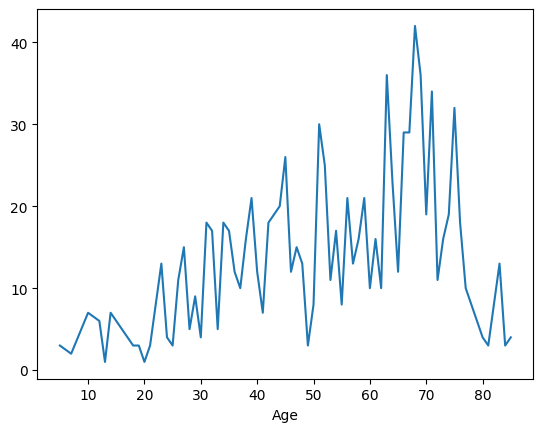

In [12]:
df_case['Age'].value_counts().sort_index().plot()#.reset_index()#.plot()

## Filter_PttBasicWD

In [13]:
##################################
FilterMethod = 'Filter_PttBasicWD'
##################################
import inspect

def fn_case_filtering(df_case):
    df_case = df_case[df_case['Age'] >= 18].reset_index(drop = True)
    return df_case

fn_case_filtering.fn_string = inspect.getsource(fn_case_filtering)

In [14]:
from recfldtkn.loadtools import convert_variables_to_pystirng

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_case_filtering]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{FilterMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/Filter_PttBasicWD.py


In [15]:
# Trigger2LearningCaseMethod
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{FilterMethod}.py')
module = load_module_variables(pypath)
fn_case_filtering = module.fn_case_filtering

In [16]:
print(df_case.shape)
df_case = fn_case_filtering(df_case)
print(df_case.shape)

(1000, 7)
(974, 7)


<Axes: xlabel='Age'>

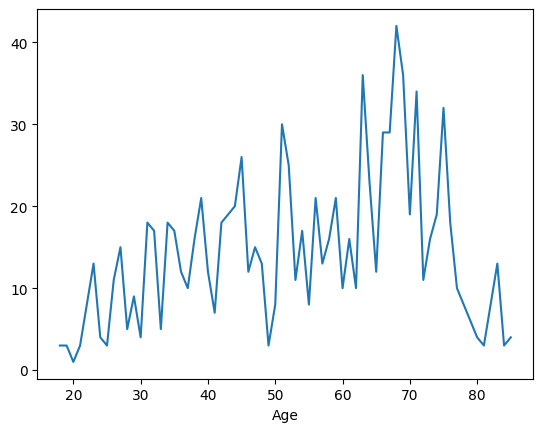

In [17]:
df_case['Age'].value_counts().sort_index().plot()#.reset_index()#.plot()

## CFQ_Bf24hCGMrn

In [18]:
##################################
CaseFeatQueryMethod = 'CFQ_Bf24hCGMrn'
##################################


import inspect
from recfldtkn.loadtools import convert_variables_to_pystirng

def fn_casefeat_querying(df_case, base_config):
    from recfldtkn.observer import get_fn_case_GammaFullInfo
    import datasets
    #############################
    Gamma_Config = {
        'case_observations': [
            'Bf24hCGMrn:ro.CGM5Min-Bf24H_ct.RecNum', # CO
        ],
        'name_CaseGamma': 'InputCatCOs', # CF
    }
    #############################
    RecName_to_dsRec = {}
    RecName_to_dsRecInfo = {}
    use_CF_from_disk = True 
    use_CO_from_disk = True
    CaseFeatInfo = get_fn_case_GammaFullInfo(Gamma_Config, 
                                                base_config, 
                                                RecName_to_dsRec, 
                                                RecName_to_dsRecInfo, 
                                                df_case,
                                                use_CF_from_disk,
                                                use_CO_from_disk)
    
    ds_case = datasets.Dataset.from_pandas(df_case)
    FnCaseFeatGamma = CaseFeatInfo['FnCaseFeatGamma']
    batch_size = CaseFeatInfo.get('batch_size', 1000)
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    CF_vocab = CaseFeatInfo['CF_vocab']
    ds_case = ds_case.map(FnCaseFeatGamma, 
                            batched = True, 
                            batch_size= batch_size, 
                            load_from_cache_file = False, 
                            new_fingerprint = CaseFeatName)
    rename_dict = {i: CaseFeatName + ':' + i for i in CF_vocab}
    df_case = ds_case.to_pandas().rename(columns=rename_dict)
    return df_case, CaseFeatInfo

fn_casefeat_querying.fn_string = inspect.getsource(fn_casefeat_querying)

In [19]:
df_case, CaseFeatInfo = fn_casefeat_querying(df_case, base_config)
df_case

[INFO:2024-03-03 22:25:12,894:(observer.py@892 recfldtkn.observer)]: provided casefeat_ids num: 974
[INFO:2024-03-03 22:25:12,905:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 974


Map:   0%|          | 0/974 [00:00<?, ? examples/s]

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]"
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]"
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]"
3,1001807,2021-09-25 04:30:00,1,1962,2,C1,59,"[1, 2]","[245.0, 1440.0]"
4,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]"
...,...,...,...,...,...,...,...,...,...
969,1001942,2021-11-25 16:05:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]"
970,1002840,2021-12-07 20:10:00,2,1957,2,C1,64,"[1, 2]","[289.0, 1440.0]"
971,1000024,2021-01-26 05:00:00,1,1990,1,C1,31,"[1, 2]","[285.0, 1440.0]"
972,1004164,2021-11-27 09:35:00,1,1981,1,C1,40,"[1, 2]","[289.0, 1440.0]"


In [20]:
# save to py
prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_casefeat_querying]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{CaseFeatQueryMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

# Trigger2LearningCaseMethod
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{CaseFeatQueryMethod}.py')
module = load_module_variables(pypath)
fn_casefeat_querying = module.fn_casefeat_querying

../pipeline/fn_learning/CFQ_Bf24hCGMrn.py


## TagCF_Bf24hCGMrn

In [21]:
##################################
TagCaseFeatMethod = 'TagCF_Bf24hCGMrn'
##################################

import inspect

def fn_case_tagging_on_casefeat(df_case, CaseFeatInfo):
    CF_vocab = CaseFeatInfo['CF_vocab']
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    input_ids_name = CaseFeatName + ':' + 'input_ids'
    input_wgts_name = CaseFeatName + ':' + 'input_wgts'
    tkn_name = 'Bf24hCGMrn:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfCGMrn'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)
    return df_case

fn_case_tagging_on_casefeat.fn_string = inspect.getsource(fn_case_tagging_on_casefeat)

In [22]:
df_case = fn_case_tagging_on_casefeat(df_case, CaseFeatInfo)
df_case.head()

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts,BfCGMrn
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]",289.0
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]",289.0
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]",289.0
3,1001807,2021-09-25 04:30:00,1,1962,2,C1,59,"[1, 2]","[245.0, 1440.0]",245.0
4,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0


In [23]:
from recfldtkn.loadtools import convert_variables_to_pystirng

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_case_tagging_on_casefeat] # <----------------
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagCaseFeatMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

# Trigger2LearningCaseMethod
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagCaseFeatMethod}.py')
module = load_module_variables(pypath)
fn_case_tagging_on_casefeat = module.fn_case_tagging_on_casefeat

../pipeline/fn_learning/TagCF_Bf24hCGMrn.py


## CFQ_Af2hCGM

In [24]:
##################################
CaseFeatQueryMethod = 'CFQ_Af2hCGMrn'
##################################
import inspect

def fn_casefeat_querying(df_case, base_config):
    from recfldtkn.observer import get_fn_case_GammaFullInfo
    import datasets
    #############################
    Gamma_Config = {
        'case_observations': [
            'Af2hCGMrn:ro.CGM5Min-Af2H_ct.RecNum', # CO
        ],
        'name_CaseGamma': 'InputCatCOs', # CF
    }
    #############################
    RecName_to_dsRec = {}
    RecName_to_dsRecInfo = {}
    use_CF_from_disk = True 
    use_CO_from_disk = True
    CaseFeatInfo = get_fn_case_GammaFullInfo(Gamma_Config, 
                                                base_config, 
                                                RecName_to_dsRec, 
                                                RecName_to_dsRecInfo, 
                                                df_case,
                                                use_CF_from_disk,
                                                use_CO_from_disk)
    
    ds_case = datasets.Dataset.from_pandas(df_case)
    FnCaseFeatGamma = CaseFeatInfo['FnCaseFeatGamma']
    batch_size = CaseFeatInfo.get('batch_size', 1000)
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    CF_vocab = CaseFeatInfo['CF_vocab']
    ds_case = ds_case.map(FnCaseFeatGamma, 
                            batched = True, 
                            batch_size= batch_size, 
                            load_from_cache_file = False, 
                            new_fingerprint = CaseFeatName)
    rename_dict = {i: CaseFeatName + ':' + i for i in CF_vocab}
    df_case = ds_case.to_pandas().rename(columns=rename_dict)
    return df_case, CaseFeatInfo

fn_casefeat_querying.fn_string = inspect.getsource(fn_casefeat_querying)

In [25]:
df_case, CaseFeatInfo = fn_casefeat_querying(df_case, base_config)
df_case

[INFO:2024-03-03 22:25:17,011:(observer.py@892 recfldtkn.observer)]: provided casefeat_ids num: 974
[INFO:2024-03-03 22:25:17,021:(observer.py@582 recfldtkn.observer)]: provided caseobs_ids num: 974


Map:   0%|          | 0/974 [00:00<?, ? examples/s]

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts,BfCGMrn,cf.InputCatCOs_co.sxoXk4R-ae:input_ids,cf.InputCatCOs_co.sxoXk4R-ae:input_wgts
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"
3,1001807,2021-09-25 04:30:00,1,1962,2,C1,59,"[1, 2]","[245.0, 1440.0]",245.0,"[1, 2]","[24.0, 115.0]"
4,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
969,1001942,2021-11-25 16:05:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"
970,1002840,2021-12-07 20:10:00,2,1957,2,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"
971,1000024,2021-01-26 05:00:00,1,1990,1,C1,31,"[1, 2]","[285.0, 1440.0]",285.0,"[1, 2]","[24.0, 115.0]"
972,1004164,2021-11-27 09:35:00,1,1981,1,C1,40,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]"


In [26]:
# save to py
from recfldtkn.loadtools import convert_variables_to_pystirng
prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_casefeat_querying]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{CaseFeatQueryMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)


# load from py
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{CaseFeatQueryMethod}.py')
module = load_module_variables(pypath)
fn_casefeat_querying = module.fn_casefeat_querying

../pipeline/fn_learning/CFQ_Af2hCGMrn.py


## TagCF_Af2hCGMrn

In [27]:
##################################
TagCaseFeatMethod = 'TagCF_Af2hCGMrn'
##################################

import inspect

def fn_case_tagging_on_casefeat(df_case, CaseFeatInfo):
    CF_vocab = CaseFeatInfo['CF_vocab']
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    input_ids_name = CaseFeatName + ':' + 'input_ids'
    input_wgts_name = CaseFeatName + ':' + 'input_wgts'

    tkn_name = 'Af2hCGMrn:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['AfCGMrn'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    return df_case

fn_case_tagging_on_casefeat.fn_string = inspect.getsource(fn_case_tagging_on_casefeat)

In [28]:
df_case = fn_case_tagging_on_casefeat(df_case, CaseFeatInfo)
df_case.head()

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts,BfCGMrn,cf.InputCatCOs_co.sxoXk4R-ae:input_ids,cf.InputCatCOs_co.sxoXk4R-ae:input_wgts,AfCGMrn
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0
3,1001807,2021-09-25 04:30:00,1,1962,2,C1,59,"[1, 2]","[245.0, 1440.0]",245.0,"[1, 2]","[24.0, 115.0]",24.0
4,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0


In [29]:
from recfldtkn.loadtools import convert_variables_to_pystirng

# save to py
prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_case_tagging_on_casefeat] # <----------------
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagCaseFeatMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

# load from py
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagCaseFeatMethod}.py')
module = load_module_variables(pypath)
fn_case_tagging_on_casefeat = module.fn_case_tagging_on_casefeat

../pipeline/fn_learning/TagCF_Af2hCGMrn.py


## Filter_BfCGMgeq280

In [30]:
##################################
FilterMethod = 'Filter_BfCGMgeq280'
##################################
import inspect

def fn_case_filtering(df_case):
    df_case = df_case[df_case['BfCGMrn'] >= 280].reset_index(drop = True)
    return df_case

fn_case_filtering.fn_string = inspect.getsource(fn_case_filtering)

In [31]:
from recfldtkn.loadtools import convert_variables_to_pystirng

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_case_filtering]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{FilterMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/Filter_BfCGMgeq280.py


In [32]:
# Trigger2LearningCaseMethod
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{FilterMethod}.py')
module = load_module_variables(pypath)
fn_case_filtering = module.fn_case_filtering

In [33]:
print(df_case.shape)
df_case = fn_case_filtering(df_case)
print(df_case.shape)

(974, 13)
(760, 13)


## Filter_AfCGMgeq24

In [34]:
##################################
FilterMethod = 'Filter_AfCGMgeq24'
##################################
import inspect

def fn_case_filtering(df_case):
    df_case = df_case[df_case['AfCGMrn'] >= 24].reset_index(drop = True)
    return df_case

fn_case_filtering.fn_string = inspect.getsource(fn_case_filtering)

In [35]:
from recfldtkn.loadtools import convert_variables_to_pystirng

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_case_filtering]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{FilterMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline/fn_learning/Filter_AfCGMgeq24.py


In [36]:
# Trigger2LearningCaseMethod
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{FilterMethod}.py')
module = load_module_variables(pypath)
fn_case_filtering = module.fn_case_filtering

In [37]:
print(df_case.shape)
df_case = fn_case_filtering(df_case)
print(df_case.shape)

(760, 13)
(729, 13)


## CFQ_Bf1mMEDALrn

In [38]:
##################################
CaseFeatQueryMethod = 'CFQ_Bf1mMEDALrn'
##################################
import inspect

def fn_casefeat_querying(df_case, base_config):
    from recfldtkn.observer import get_fn_case_GammaFullInfo
    import datasets
    #############################
    Gamma_Config = {
        'case_observations': [
            # Med
            'Bf1mMedPresRN:ro.MedPres-Bf1M_ct.RecNum',
            'Bf1mMedAdminRN:ro.MedAdmin-Bf1M_ct.RecNum',
            'Bf1mImpMedRN:ro.ImpMed-Bf1M_ct.RecNum',

            # Edu
            'Bf1mCmtRN:ro.Cmt-Bf1M_ct.RecNum',
            'Bf1mLessonProgRN:ro.LessonProg-Bf1M_ct.RecNum',

            # Diet
            'Bf1mFoodRecRN:ro.FoodRec-Bf1M_ct.RecNum', 
            'Bf1mCarbRN:ro.Carb-Bf1M_ct.RecNum',

            # Activity
            'Bf1mExerciseRecRN:ro.Exercise-Bf1M_ct.RecNum',
            'Bf1mSleepRecRN:ro.Sleep-Bf1M_ct.RecNum',
            'Bf1mStepRecRN:ro.Step-Bf1M_ct.RecNum',

            # LabVital
            'Bf1mBPrn:ro.BP-Bf1M_ct.RecNum',
            'Bf1mWeighUrn:ro.WeightU-Bf1M_ct.RecNum',
            'Bf1mLabTestRN:ro.LabTestResult-Bf1M_ct.RecNum',

            # CO
        ],
        'name_CaseGamma': 'InputCatCOs', # CF
    }
    #############################

    RecName_to_dsRec = {}
    RecName_to_dsRecInfo = {}
    use_CF_from_disk = False 
    use_CO_from_disk = True
    CaseFeatInfo = get_fn_case_GammaFullInfo(Gamma_Config, 
                                                base_config, 
                                                RecName_to_dsRec, 
                                                RecName_to_dsRecInfo, 
                                                df_case,
                                                use_CF_from_disk,
                                                use_CO_from_disk)
    
    ds_case = datasets.Dataset.from_pandas(df_case)

    FnCaseFeatGamma = CaseFeatInfo['FnCaseFeatGamma']
    batch_size = CaseFeatInfo.get('batch_size', 1000)
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    CF_vocab = CaseFeatInfo['CF_vocab']


    ds_case = ds_case.map(FnCaseFeatGamma, 
                            batched = True, 
                            batch_size= batch_size, 
                            load_from_cache_file = False, 
                            new_fingerprint = CaseFeatName)
     
    rename_dict = {i: CaseFeatName + ':' + i for i in CF_vocab}
    df_case = ds_case.to_pandas().rename(columns=rename_dict)
    return df_case, CaseFeatInfo

fn_casefeat_querying.fn_string = inspect.getsource(fn_casefeat_querying)

In [39]:
df_case, CaseFeatInfo = fn_casefeat_querying(df_case, base_config)
df_case

[INFO:2024-03-03 22:25:19,240:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/2-RawData2023_CVSTDCAug/MedPres_data ...
[INFO:2024-03-03 22:25:19,241:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/3-RawData2023_CVSDeRxAug/MedPres_data ...


[INFO:2024-03-03 22:25:19,262:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/2-RawData2023_CVSTDCAug/MedAdmin_data ...
[INFO:2024-03-03 22:25:19,263:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/3-RawData2023_CVSDeRxAug/MedAdmin_data ...
[INFO:2024-03-03 22:25:19,285:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/2-RawData2023_CVSTDCAug/ImpMed_data ...
[INFO:2024-03-03 22:25:19,286:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/3-RawData2023_CVSDeRxAug/ImpMed_data ...
[INFO:2024-03-03 22:25:19,299:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/2-RawData2023_CVSTDCAug/Cmt_data ...
[INFO:2024-03-03 22:25:19,300:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/3-RawData2023_CVSDeRxAug/Cmt_data ...
[INFO:2024-03-03 22:25:19,310:(loadtools.py@146 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT/1-RawData2

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts,BfCGMrn,cf.InputCatCOs_co.sxoXk4R-ae:input_ids,cf.InputCatCOs_co.sxoXk4R-ae:input_wgts,AfCGMrn,cf.InputCatCOs_co.YWHiEx96pF:input_ids,cf.InputCatCOs_co.YWHiEx96pF:input_wgts
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1001088,2021-08-05 21:05:00,2,1953,1,C1,68,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,1001942,2021-11-25 16:05:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
725,1002840,2021-12-07 20:10:00,2,1957,2,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
726,1000024,2021-01-26 05:00:00,1,1990,1,C1,31,"[1, 2]","[285.0, 1440.0]",285.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
727,1004164,2021-11-27 09:35:00,1,1981,1,C1,40,"[1, 2]","[289.0, 1440.0]",289.0,"[1, 2]","[24.0, 115.0]",24.0,"[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [40]:
# save to py
from recfldtkn.loadtools import convert_variables_to_pystirng

prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_casefeat_querying]
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{CaseFeatQueryMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

# load from py 
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{CaseFeatQueryMethod}.py')
module = load_module_variables(pypath)
fn_casefeat_querying = module.fn_casefeat_querying

../pipeline/fn_learning/CFQ_Bf1mMEDALrn.py


In [41]:
CaseFeatInfo['CaseFeatName']

'cf.InputCatCOs_co.YWHiEx96pF'

In [42]:
CaseFeatInfo['CF_vocab']

{'input_ids': {'tid2tkn': {0: 'Bf1mMedPresRN:[UNK]',
   1: 'Bf1mMedPresRN:recnum',
   2: 'Bf1mMedPresRN:recspan',
   3: 'Bf1mMedAdminRN:[UNK]',
   4: 'Bf1mMedAdminRN:recnum',
   5: 'Bf1mMedAdminRN:recspan',
   6: 'Bf1mImpMedRN:[UNK]',
   7: 'Bf1mImpMedRN:recnum',
   8: 'Bf1mImpMedRN:recspan',
   9: 'Bf1mCmtRN:[UNK]',
   10: 'Bf1mCmtRN:recnum',
   11: 'Bf1mCmtRN:recspan',
   12: 'Bf1mLessonProgRN:[UNK]',
   13: 'Bf1mLessonProgRN:recnum',
   14: 'Bf1mLessonProgRN:recspan',
   15: 'Bf1mFoodRecRN:[UNK]',
   16: 'Bf1mFoodRecRN:recnum',
   17: 'Bf1mFoodRecRN:recspan',
   18: 'Bf1mCarbRN:[UNK]',
   19: 'Bf1mCarbRN:recnum',
   20: 'Bf1mCarbRN:recspan',
   21: 'Bf1mExerciseRecRN:[UNK]',
   22: 'Bf1mExerciseRecRN:recnum',
   23: 'Bf1mExerciseRecRN:recspan',
   24: 'Bf1mSleepRecRN:[UNK]',
   25: 'Bf1mSleepRecRN:recnum',
   26: 'Bf1mSleepRecRN:recspan',
   27: 'Bf1mStepRecRN:[UNK]',
   28: 'Bf1mStepRecRN:recnum',
   29: 'Bf1mStepRecRN:recspan',
   30: 'Bf1mBPrn:[UNK]',
   31: 'Bf1mBPrn:recnum',
  

## TagCF_Bf1mMEDALrn

In [43]:
##################################
TagCaseFeatMethod = 'TagCF_Bf1mMEDALrn'
##################################

import inspect


def fn_case_tagging_on_casefeat(df_case, CaseFeatInfo):
    CF_vocab = CaseFeatInfo['CF_vocab']
    CaseFeatName = CaseFeatInfo['CaseFeatName']
    input_ids_name = CaseFeatName + ':' + 'input_ids'
    input_wgts_name = CaseFeatName + ':' + 'input_wgts'

    tkn_name = 'Bf1mMedPresRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfMedPresRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mMedAdminRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfMedAdminRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mImpMedRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfImpMedRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mCmtRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfCmtRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mLessonProgRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfLessonProgRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mFoodRecRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfFoodRecRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)
    
    tkn_name = 'Bf1mCarbRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfCarbRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mExerciseRecRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfExerciseRecRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mSleepRecRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfSleepRecRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mStepRecRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfStepRecRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mBPrn:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfBPRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mWeighUrn:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfWeighURN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    tkn_name = 'Bf1mLabTestRN:recnum'
    tkn_id = CF_vocab['input_ids']['tkn2tid'][tkn_name]
    df_case['BfLabTestRestRN'] = df_case.apply(lambda x: x[input_wgts_name][list(x[input_ids_name]).index(tkn_id)], axis = 1)

    MEDAL_list = ['BfMedPresRN', 'BfMedAdminRN', 'BfImpMedRN', 
                  'BfCmtRN', 'BfLessonProgRN', 
                  'BfFoodRecRN', 'BfCarbRN',
                    'BfExerciseRecRN', 'BfSleepRecRN', 'BfStepRecRN', 
                    'BfBPRN', 'BfWeighURN', 'BfLabTestRestRN']
    df_case['MEDALrn'] = df_case[MEDAL_list].sum(axis = 1)
    return df_case

fn_case_tagging_on_casefeat.fn_string = inspect.getsource(fn_case_tagging_on_casefeat)

In [44]:
df_case = fn_case_tagging_on_casefeat(df_case, CaseFeatInfo)
df_case.head()

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts,BfCGMrn,...,BfLessonProgRN,BfFoodRecRN,BfCarbRN,BfExerciseRecRN,BfSleepRecRN,BfStepRecRN,BfBPRN,BfWeighURN,BfLabTestRestRN,MEDALrn
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,40.0,0.0,10.0,0.0,0.0,0.0,50.0
4,1001088,2021-08-05 21:05:00,2,1953,1,C1,68,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_case

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,cf.InputCatCOs_co.OQTPe73SNH:input_ids,cf.InputCatCOs_co.OQTPe73SNH:input_wgts,BfCGMrn,...,BfLessonProgRN,BfFoodRecRN,BfCarbRN,BfExerciseRecRN,BfSleepRecRN,BfStepRecRN,BfBPRN,BfWeighURN,BfLabTestRestRN,MEDALrn
0,1002319,2021-08-16 02:10:00,1,1976,2,C1,45,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001911,2021-06-21 11:20:00,1,1994,2,C1,27,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000987,2021-11-23 19:05:00,2,1957,1,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1001452,2021-12-01 01:35:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,40.0,0.0,10.0,0.0,0.0,0.0,50.0
4,1001088,2021-08-05 21:05:00,2,1953,1,C1,68,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,1001942,2021-11-25 16:05:00,2,1974,2,C1,47,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,22.0,97.0,15.0,6.0,0.0,0.0,140.0
725,1002840,2021-12-07 20:10:00,2,1957,2,C1,64,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
726,1000024,2021-01-26 05:00:00,1,1990,1,C1,31,"[1, 2]","[285.0, 1440.0]",285.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
727,1004164,2021-11-27 09:35:00,1,1981,1,C1,40,"[1, 2]","[289.0, 1440.0]",289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
from recfldtkn.loadtools import convert_variables_to_pystirng

# save to py
prefix = ['import pandas as pd', 'import numpy as np']
fn_variables = [fn_case_tagging_on_casefeat] # <----------------
pycode = convert_variables_to_pystirng(fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagCaseFeatMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

# load from py
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagCaseFeatMethod}.py')
module = load_module_variables(pypath)
fn_case_tagging_on_casefeat = module.fn_case_tagging_on_casefeat

../pipeline/fn_learning/TagCF_Bf1mMEDALrn.py
